## **How Well Can a Player’s Total Hours Played (played_hours) and their Experience Level Predict Whether They Subscribe to a Games-Related Newsletter?**

## Introduction

In the gaming industry, player engagement is critical to a game's long term success. Gaming newsletters often lists out updates, promotes rewards and events, and gives the players an opportunity to provide feedback on the game. Newsletters are a valuable strategy to maintain player interests, and the decisiont to subscribe to a newsletter can reflect a deeper loyalty to the game. Undeerstandint what types of players are more likely to subscribe can help game developers be more efficient in marketing, and player outreach. In this analysis, we will explore **how well can total hours played and self reported experience level predict whether a player subscribes to a games-related newsletter.** Together, these variables may reflect different types of players: casual users who engage briefly versus dedicated players who are more likely to stay connected with game updates. By applying the K nearest neighbors classification model, we aim to predict subscription behavior based on these traits and uncover patterns that could inform game marketing and player engagement strategies.

### Data Description

To explore whether player behavior and experience predict newsletter subscription, we used a dataset containing information on 196 unique players. The dataset includes both behavioral and demographic information about each player. Each observation represents a single player and is uniquely identified by a hashed email address. The dataset contains a total of 7 variables, but this analysis focuses on two predictors: played hours(numerical) and experience (categorical). The outcome variable of interest is subscribe, which indicates whether the player subscribed to a games-related newsletter.

The dataset is clean, with each email appearing only once, suggesting no duplicate entries, and no missing values for the main analysis variables. However, a small number of entries are missing values in the Age column (2 out of 196). Another potential concern is class imbalance, as 144 out of 196 players (73%) subscribed to the newsletter, while only 52 did not. This could affect classification performance and will be taken into account during model evaluation.

The data appears to have been collected from player activity logs and self-reported survey fields (e.g., experience and gender), though the exact method of data collection is not detailed. Additional variables such as name, gender, and age were available but not used in this analysis.

## Methods

### Preprocessing Steps

1. Imported the necessary libraries and loaded the players.csv dataset from Canvas.
2. Cleaned and prepared the dataset by re-assigning the experience variable as a factorial.
3. Split the data into training and testing sets.
4. Used the training set to guide the dedsign of the classifier model.

### Finding the Best K Value

Our objective is to determine the optimal number of neighbors (k) for a K-nearest neighbors classifier that yields the highest prediction accuracy. In the following steps, we build a classification model and apply cross-validation to evaluate its performance without using the testing data prematurely.

1. To prepare the data for K-nearest neighbors classification, we created a recipe that includes both categorical and numeric predictors. We used step_dummy() to one-hot encode the experience factor, allowing the model to handle categorical inputs appropriately. We also applied step_normalize() to ensure that played_hours is scaled properly. This preprocessing ensures that all predictors contribute meaningfully to distance calculations in the KNN algorithm.

2. Next, we perform 10-fold cross-validation on the training data using vfold_cv(). Using multiple folds reduces the risk of overfitting to a single validation split and provides a more reliable estimate of model performance.

3. We then define a KNN model with neighbors = tune() to allow for automated tuning of the best k value, rather than selecting one arbitrarily.

4. This model and preprocessing recipe are combined into a workflow, which we fit using tune_grid() across a specified range of k values (provided in gridvals). This tuning process is repeated across each fold in the cross-validation.

5. To identify the best-performing model, we filter the results for accuracy and create a line plot showing accuracy estimates against different k values.

## Preprocessing Steps

### Importing Libraries

In [196]:
#
library(tidyverse)
library(tidymodels)
library(repr)
library(RColorBrewer)

### Importing the Dataset

In [197]:
players<-read_csv("players.csv")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Tidying the Data

Before fitting the classification model, we prepared the dataset by ensuring that key variables were correctly formatted for modeling.Specifically, we converted both the experience and subscribe columns to factor variables using the mutate() function.

The experience variable, which originally consisted of character strings indicating a player's self-reported skill level (e.g., "Beginner", "Pro"), was converted into a factor. This allows modeling functions to treat it as a categorical predictor.

Similarly, the response variable subscribe, which initially appeared as a logical (TRUE/FALSE) column, was also converted into a factor with two levels. This is a standard requirement for classification models in R, particularly when using the tidymodels framework because classification outcomes must be explicitly specified as categorical.

In [198]:
players_tidy <- players |>
  mutate(experience = as.factor(experience)) |>
  mutate(subscribe = as.factor(subscribe))
head(players_tidy)

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<fct>,<fct>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


### Splitting Data into Training and Testing Sets

To evaluate our model effectively, the dataset was divided into a training set and a testing set using the initial_split() function. Seventy-five percent of the data was allocated to the training set, while the remaining 25% was reserved for final model testing. This split allows me to train and tune the model on one portion of the data while preserving an unseen subset for unbiased evaluation. Stratified sampling was applied based on the subscribe variable using the strata argument. This approach preserved the original proportion of subscribers and non subscribers in both the training and testing sets.

The resulting training set (players_training) was used for model building and cross-validation, while the testing set (players_testing) was held out and used only at the end of the analysis to assess the model’s final performance.

In [199]:
players_split <- initial_split(players_tidy , prop = 0.75, strata = subscribe)
players_training <- training(players_split)
players_testing <- testing(players_split)

head(players_training)

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<fct>,<fct>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Veteran,FALSE,f8acd26a5e452b682b9f8b20108caef1ee2e745efe08e95806980bd2388a3fea,0.0,Finn,Male,23
Veteran,FALSE,88247d9a46fc214a12485dcbcbb03a8ddebfe8c1ec5fe209cd660147625c8e62,1.4,Aiden,Prefer not to say,25
Beginner,FALSE,fa7d496b2f74c51ec70395bd8397b49f97a3ce8d7ba7e08887d82ec0008137a7,0.0,Umar,Male,24
Regular,FALSE,453774822d52d6891593948224570a750c4334616ff8aa74cd61fad9d4855752,0.0,Edmund,Prefer not to say,23
Amateur,FALSE,5c27e8b9fed2816b006dc8397ec04470b59339fd591a46a3eb7951b939b72984,0.9,Pablo,Male,18
Beginner,FALSE,5e5c25a773be7a62638a163d773534e575a5ad5782104723e53cb676a30fa60b,0.0,Jude,Female,42


### Summarizing the Data

An initial exploration of the training and testing datasets was conducted to examine the distribution of key variables across subscription status. The experience variable was summarized using grouped counts within each level of the subscribe outcome for both the training and testing sets. The results showed that the distribution of experience levels: from Beginner to Veteran, was relatively balanced across both subsets and did not have much nfluence on subscription status. 

Additionally, the played_hours variable was also summarized. From what was observed, players who subscribed tended to have much higher average hours played compared to those who did not subscribe, suggesting that gameplay engagement may be positively associated with the likelihood of subscription.

In [200]:
players_training_experience <- player_training %>%
                    group_by(subscribe) %>%
                    count(experience, subscribe)
players_testing_experience <- player_testing %>%
                    group_by(subscribe) %>%
                    count(experience, subscribe)
players_training_hours <- player_training %>%
                    group_by(subscribe) %>%
                    summarize(mean_hours = mean(played_hours),
                              n_of_patients = n())
players_testing_hours <- player_testing %>%
                    group_by(subscribe) %>%
                    summarize(mean_hours = mean(played_hours),
                              n_of_patients = n())

players_training_experience
players_testing_experience
players_training_hours
players_testing_hours

subscribe,experience,n
<fct>,<fct>,<int>
FALSE,Amateur,14
FALSE,Beginner,6
FALSE,Pro,3
FALSE,Regular,5
FALSE,Veteran,11
TRUE,Amateur,36
TRUE,Beginner,20
TRUE,Pro,9
TRUE,Regular,17


subscribe,experience,n
<fct>,<fct>,<int>
FALSE,Amateur,4
FALSE,Beginner,2
FALSE,Pro,1
FALSE,Regular,2
FALSE,Veteran,4
TRUE,Amateur,9
TRUE,Beginner,7
TRUE,Pro,1
TRUE,Regular,12


subscribe,mean_hours,n_of_patients
<fct>,<dbl>,<int>
FALSE,0.4153846,39
TRUE,6.4009259,108


subscribe,mean_hours,n_of_patients
<fct>,<dbl>,<int>
FALSE,0.7615385,13
TRUE,11.9000000,36


### Finding the Best K Value

To build a classification model capable of predicting newsletter subscription based on player experience and total hours played, a KNN classifier was implemented. A preprocessing recipe was defined using the recipe() function, including encoding of cateogrical variables via step_dummy() and normalizinggnumeric predictors using step_normalize. This preprocessing was necessary to ensure that categorical values were appropriately represented. A KNN model specification was created with neighbors = tune(). To identify the optimal value of k, a 10-fold cross-validation procedure was conducted on the training set using the vfold_cv() function. A grid of candidate values for k ranging from 1 to 15 was created using tibble() and passed to the tuning function. The model performance was evaluated based on classification accuracy.

As shown in the results, accuracy tended to increase with larger values of k, but would plateau beyond k=15. A final value of k=11 was chosen to balance accuracy and prevent model flattening. As observed, k=11 was the greatest out of all 15 values.

In [218]:
players_recipe <- recipe(subscribe~experience+played_hours, data = player_training) %>%
  step_dummy(all_nominal_predictors()) %>%
   step_normalize(all_numeric_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
            set_engine("kknn") %>%
            set_mode("classification")

players_vfold <- vfold_cv(player_training, v = 10, strata = subscribe)

gridvals <- tibble(neighbors = c(1:15))

knn_results <- workflow() %>%
      add_recipe(players_recipe) %>%
      add_model(knn_spec) %>%
      tune_grid(resamples = players_vfold, grid = gridvals) %>%
      collect_metrics() %>%
      filter(.metric == "accuracy") %>%
      select(neighbors, mean) %>%
      arrange(desc(mean))

head(knn_results)

neighbors,mean
<int>,<dbl>
11,0.7007326
12,0.7001832
15,0.6940659
14,0.6935897
13,0.6863736
10,0.6540659


### Visualizing Accuracy

To assess how the number of neighbors affects model performance, a line plot was created to visualize the relationship between
k and classification accuracy. As shown in the figure, The curve begins to flatten at around k=11 where the accuracy reaches its peak before showing small fluctuations. Any additional k past k=11 shows flattening that may indicate a risk of underfitting the model. The graph helps confirm that k=11 is a good neighbors value.

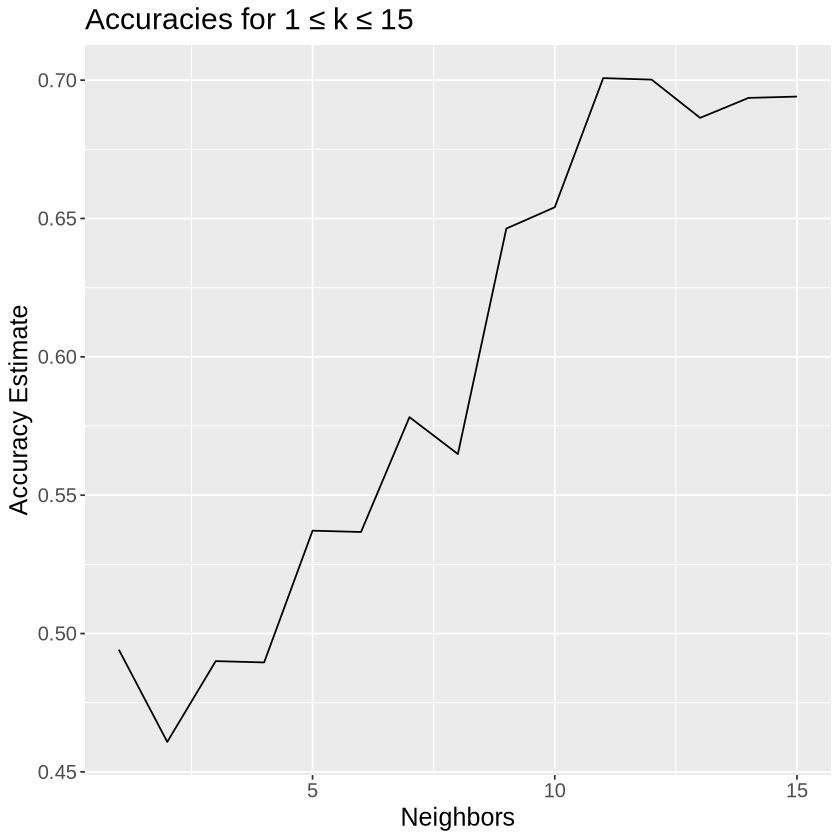

In [231]:
accuracy_versus_k <- ggplot(knn_results, aes(x = neighbors, y = mean))+
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate", title = "Accuracies for 1 ≤ k ≤ 15") +
      scale_x_continuous(breaks = seq(0, 100, by = 5)) + 
      theme(text = element_text(size = 15))

accuracy_versus_k

### Building the Model with K=11

The KNN model is specified using k=11. This final model will be trained on the full training data set using the fit() function, which will be prepared for use in making predictions for the test set.

In [228]:
players_k_spec <- nearest_neighbor(weight_func="rectangular", neighbors = 11)%>%
    set_engine("kknn")%>%
    set_mode("classification")

players_fit <- workflow()%>%
    add_recipe(players_recipe)%>%
    add_model(players_k_spec)%>%
    fit(data = players_training)
players_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_dummy()
• step_normalize()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(11,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2993197
Best kernel: rectangular
Best k: 11

### Final Model Evaluation
After training the final K-nearest neighbors model with k=11, its performance was evaluated on the testing dataset to assess generalization to unseen data.

Model performance was assessed using the metrics() function, focusing on classification accuracy as the main metric. Accuracy was calculated by comparing the model's predicted class labels to the true subscription values in the testing dataset. The model achieved an accuracy of approximately 69.39% on the testing data. This indicates that the model correctly predicted newsletter subscription status for about 69% of the players in the test set.

In [232]:
players_testing_predict <- predict(players_fit, players_testing) %>%
               bind_cols(players_testing) 
players_testing_metrics<- players_testing_predict %>%
               metrics(truth = subscribe, estimate = .pred_class) %>%
    filter(.metric == "accuracy")
players_testing_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6938776


### Confusion Matrix

To further evaluate the performance of the final K-nearest neighbors classification model, a confusion matrix was generated using the conf_mat() function. This matrix provides insight into the model's classification behavior beyond overall accuracy. While the model is better at identifying positive cases (subscriptions), the false positive rate indicates a tendency to over-predict the majority class. This is consistent with the moderate class imbalance observed in the dataset. 

In [233]:
conf_mat<- players_testing_predict %>%
    conf_mat(truth = subscribe, estimate = .pred_class)
conf_mat

          Truth
Prediction FALSE TRUE
     FALSE     5    7
     TRUE      8   29

## Discussion

The KNN classification model developed in this analysis achieved an overall accuracy of approximately 69.4% when applied to unknown data from the testing set. This suggests that the model was not very successful in predicting whether a player subscribes to a game related newsletter using two predictors: total hours played and experience level. The confusion matrix shows a bias towards predicting "subscribe=TRUE", which aligns with the fact that the majority of the players in the data set were actually subscribers. This imbalance likely influenced the model’s prediction behavior, leading to a higher number of false positives than expected.

This outcome is partially in line with expectations that subscribers who on average had more hours played showed relatively higher engagement levels. However, the poor accuracy and misclassifications suggest that played_hours and experience level alone are not sufficient for an accurate prediction. Additional unobserved factors, such as player satisfaction could improve the classification if included.

The implications of these findings could be relevant for game marketing teams, who may use similar models to predict player engagement and improve marketing strategies. Being able to better identify likely subscribers could enhance communication effectiveness and increase player retention.

One main future questions to consider would be to incorporate additional behavioral metrics such as player satisfaction or time between sessions could improve predictive power. Overall, while the current model demonstrates promising direction, it also highlights the limitations of using these two predictors to predict newsletter subscribers.